# WDIS: Service for OCpR 

### Import Statements

In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt

### Utility Functions

In [2]:
def filter_out_descriptions_and_non_tags(df):
    sku_desc_filter_out = lambda x: 'sku_desc' not in x
    sku_qty_tag = lambda x: not( ('sku' not in x) and ('qty' not in x) and ('tag' not in x))
    cols_non_desc =  list(filter(sku_desc_filter_out, df.columns.to_list()))
    
    cols_non_desc =  list(filter(sku_qty_tag, cols_non_desc))
    
    
    return copy.copy(df[cols_non_desc])

In [3]:
def filter_out_tags(df):
    sku_w_tags = lambda x: 'tag' not in x
    cols_non_desc =  list(filter(sku_w_tags, df.columns.to_list()))
    return copy.copy(df[cols_non_desc])

In [4]:
def keep_tags(df):
    sku_w_tags = lambda x: 'tag' in x
    cols_tags =  list(filter(sku_w_tags, df.columns.to_list()))
    return copy.copy(df[cols_tags])

In [5]:
def column_renamer(df, sheet_name):
    df.columns = [ sheet_name+'_' + x if (('sku' in x) or ('qty' in x)) else x for x in  df.columns.to_list()]
    return df

In [6]:
def dataframes_splitter(path_to_the_file = r'.\uploads\VxRail_E560N.xls', list_for_splits=['Street_Prices', 'List_Prices']):
    OCpR_dfs, Prices_dfs = [], []
    
    excel_ = pd.ExcelFile(path_to_the_file)

    worksheets_names = excel_.sheet_names
    for ws_ in worksheets_names:

        if (ws_ in list_for_splits) or ('Prices_' in ws_) :
            some_details = pd.read_excel(excel_, sheet_name=ws_)
            some_details.title = ws_
            Prices_dfs.append(some_details )
        else:
            df_comb = filter_out_descriptions_and_non_tags(pd.read_excel(excel_, sheet_name=ws_))
            
            OCpR_dfs.append(column_renamer(df_comb, ws_))
    
    return OCpR_dfs, Prices_dfs

In [7]:
def common_tags(df_l, df_r):
    left_ = df_l.columns.to_list()
    rigth_ = df_r.columns.to_list()
    return list(set(left_).intersection(rigth_))

In [8]:
def loop_thru_dataframes(df_list, howhow='inner'):
    ocpr_df = pd.DataFrame()
    counter =  1
    for d_ in df_list:
        if counter == 1:
            ocpr_df = d_
            counter += 1
        else:
            cmmn_tags_list = common_tags(ocpr_df, d_)
            if len(cmmn_tags_list) == 0:
                ocpr_df['comKey'] = 1
                d_['comKey'] = 1
                ocpr_df = pd.merge( ocpr_df, d_, on ='comKey', how=howhow)
                ocpr_df = ocpr_df.drop(columns=['comKey'])
            else:
                ocpr_df = pd.merge( ocpr_df, d_, on=cmmn_tags_list ,how=howhow)    
    return ocpr_df

In [9]:
def order_columns(df):
    sku_and_qty = lambda x : ('sku' in x) or ('qty' in x)
    tag = lambda x : ('tag' in x) 
    cols_ = df.columns.to_list()
    return  pd.concat( [ df[list(filter(sku_and_qty, cols_))], df[list(filter(tag, cols_))] ], axis=1)

In [10]:
def OCpR_stacker(df):
    
    OCpR_stackable = filter_out_tags(df)
    OCpR_conf_tags = keep_tags(df)
    list_to_add_as_code =[x+1 for x in  OCpR_conf_tags.index.to_list().copy()]     
    OCpR_conf_tags['code'] = list_to_add_as_code
    
    rows_to_stack = [] 
    for row in OCpR_stackable.iterrows():
        conf_number = row[0]
        example = row
        col_ = 1
        elements_to_stuck = []
        for elem_ in row[1]: 

            if col_%2 == 0:
                                
                elements_to_stuck.append(elem_)
                elements_to_stuck.append(conf_number+1)
                rows_to_stack.append(elements_to_stuck)
                elements_to_stuck = []
            else:
                elements_to_stuck.append(elem_)

            col_ +=1
    return pd.DataFrame(rows_to_stack, columns=['SKU', 'qty','code']), OCpR_conf_tags

### OCpR Process

In [60]:
dfs, details_dfs = dataframes_splitter()

In [61]:
OCpR = loop_thru_dataframes(dfs)

In [62]:
OCpR_staked, OCpR_tags = OCpR_stacker(OCpR)

In [63]:
details_dfs.insert(0,OCpR_staked)

In [64]:
df_ca = loop_thru_dataframes(details_dfs, howhow='left')

In [65]:
#ListPrices
df_ca['q_by_Lp'] = df_ca['List_Price'] * df_ca['qty']
df_ca = df_ca.fillna(0.0)
Conf_List_prices = df_ca[['code','q_by_Lp']].groupby('code').sum()
Conf_List_prices['code'] = Conf_List_prices.index
Conf_List_prices.index = Conf_List_prices.index.rename('index')

In [66]:
#StreetPrices
df_ca['q_by_Sp'] = df_ca['Street_Price'] * df_ca['qty']
df_ca = df_ca.fillna(0.0)
Conf_Street_prices = df_ca[['code','q_by_Sp']].groupby('code').sum()
Conf_Street_prices['code'] = Conf_List_prices.index
Conf_Street_prices.index = Conf_Street_prices.index.rename('index')

In [67]:
final_df = pd.merge(OCpR_tags,Conf_List_prices, on='code', how='inner')

In [68]:
final_df = pd.merge(final_df,Conf_Street_prices, on='code', how='inner')

In [69]:
final_df.head()

,CPU_level_tag,cache_limit_tag,vSAN_level_tag,N_years_service_tag,code,q_by_Lp,q_by_Sp
0,Gold,single,Enterprise,3,1,12903.0,5162.7
1,Gold,single,Enterprise,3,2,12902.0,5161.8
2,Gold,single,Enterprise,3,3,12903.0,5162.7
3,Gold,single,Enterprise,3,4,12902.0,5161.8
4,Gold,single,Enterprise,3,5,12759.0,5119.5


In [70]:
final_df['q_by_Lp/years'] = final_df['q_by_Lp'] / final_df['N_years_service_tag']

In [80]:
points = list(zip(final_df['q_by_Lp'].to_list(), final_df['q_by_Sp'].to_list()))

In [81]:
lod = []
for elem in points:
    lod.append({'x':elem[0], 'y':elem[1]})


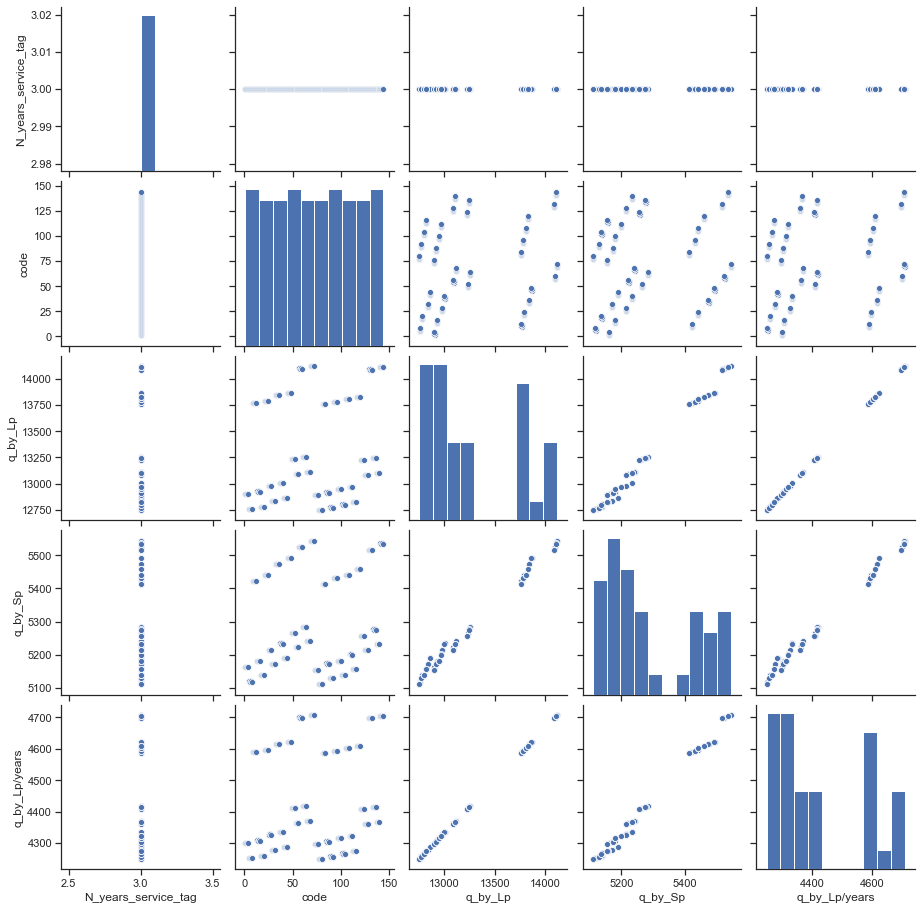

In [23]:
sns.set(style="ticks", color_codes=True) 
g = sns.pairplot(final_df)

plt.show()